In [1]:
import nltk
from collections import Counter
from sklearn.feature_extraction.text import CountVectorizer
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud
from google.colab import auth
import gspread
from google.auth import default

### Autenticacion

In [2]:
# 1. Autenticación de usuario
auth.authenticate_user()

# 2. Credenciales para la librería gspread
creds, _ = default()
gc = gspread.authorize(creds)

print("¡Autenticación exitosa!")

¡Autenticación exitosa!


### Funciones

In [3]:
import re

def simplificar_os(texto):
    # Convertimos a string y minúsculas para evitar errores de formato
    t = str(texto).lower()

    if 'mac' in t:
        return 'Mac'
    elif 'windows' in t:
        return 'Windows'
    elif any(keyword in t for keyword in ['nativa', 'virtualizado', 'wsl']):
        return 'Linux'
    else:
        return 'Desconocido' # Por si aparece algo nuevo o vacío

def consolidar_columna_texto(df, columna, separador=' '):
    """
    Toma una columna de un DataFrame y concatena todas sus filas
    en un solo string largo, ignorando valores vacíos.
    """
    # 1. Seleccionamos la columna
    serie = df[columna]

    # 2. Eliminamos los nulos (NaN) para evitar errores o texto "nan"
    serie_limpia = serie.dropna()

    # 3. Aseguramos que todo sea texto (string)
    serie_str = serie_limpia.astype(str)

    # 4. Unimos todo usando el separador elegido (por defecto un espacio)
    texto_final = serie_str.str.cat(sep=separador)

    return texto_final

def limpiar_y_estructurar_comentarios(texto_crudo, separador='&'):
    """
    Procesa una cadena de texto cruda, separa por el delimitador,
    limpia el ruido (emojis, risas, respuestas cortas) y formatea el texto.
    """

    # 1. Separar el texto
    lista_inicial = texto_crudo.split(separador)

    comentarios_limpios = []

    # Lista de palabras o frases para ignorar (Stopwords personalizadas)
    respuestas_a_ignorar = [
        "n/a", "no", "ninguna", "ninguno", "todo bien",
        "no he escuchado nada", "sin comentarios"
    ]

    for comentario in lista_inicial:
        # --- PASO A: Limpieza Básica ---
        # Quitar espacios al inicio y final
        c = comentario.strip()

        # Si quedó vacío después del strip, saltar
        if not c:
            continue

        # --- PASO B: Limpieza Profunda ---
        # 1. Eliminar risas textuales (jajaja, jejeje) sin importar mayúsculas
        c = re.sub(r'(?i)\b(j|h)+a+(j|h)+a+\b', '', c)

        # 2. Corregir Typos comunes (Ej: "C+" -> "C++" o "C")
        # Aquí asumimos que querían decir C++ o C. Lo ajustamos a un estándar.
        c = c.replace("C+", "C++")

        # 3. Eliminar Emojis y caracteres extraños (Dejando solo texto, puntuación y tildes)
        # Nota: Este regex permite letras, números, espacios y puntuación básica en español.
        c = re.sub(r'[^\w\s,.;:\-áéíóúÁÉÍÓÚñÑ¿?¡!()]', '', c)

        # 4. Formatear listas internas (cambiar guiones internos por puntos)
        # Si hay un guion seguido de texto en medio de la frase, convertirlo a una pausa.
        c = re.sub(r'\s+-\s+', '. ', c)

        # 5. Quitar espacios dobles generados por la limpieza anterior
        c = re.sub(r'\s+', ' ', c).strip()

        # --- PASO C: Filtros de Calidad ---
        # 1. Filtro de longitud mínima (menos de 5 caracteres no suele ser útil)
        if len(c) < 5:
            continue

        # 2. Filtro de contenido irrelevante (Stopwords)
        if c.lower() in respuestas_a_ignorar:
            continue

        # --- PASO D: Formato Final ---
        # Asegurar que empiece con Mayúscula y termine en punto (si no lo tiene)
        c = c[0].upper() + c[1:]
        if not c.endswith('.'):
            c += '.'

        comentarios_limpios.append(c)

    return comentarios_limpios

# --- FUNCIÓN 1: ¿Cuáles son las palabras más repetidas? ---
def analizar_frecuencia_palabras(lista_comentarios, top_n=10):
    """
    Cuenta las palabras más usadas, eliminando las que no aportan valor
    (artículos, preposiciones, y palabras obvias como 'curso' o 'materia').
    """
    # 1. Definir stopwords (palabras vacías) en español
    stop_words = set(stopwords.words('spanish'))

    # 2. Añadir "stopwords de dominio" (palabras obvias en este contexto)
    palabras_obvias = {'curso', 'materia', 'clase', 'tema', 'temas', 'ser', 'si', 'así', 'mas', 'vez'}
    stop_words.update(palabras_obvias)

    todas_palabras = []

    for comentario in lista_comentarios:
        # Tokenizar: convertir a minúsculas y separar por palabras
        palabras = comentario.lower().split()
        # Filtrar: solo alfanuméricos y que no sean stopwords
        palabras_limpias = [p for p in palabras if p.isalnum() and p not in stop_words and len(p) > 2]
        todas_palabras.extend(palabras_limpias)

    conteo = Counter(todas_palabras)

    print(f"--- TOP {top_n} PALABRAS MÁS FRECUENTES ---")
    df_freq = pd.DataFrame(conteo.most_common(top_n), columns=['Palabra', 'Frecuencia'])
    print(df_freq)
    return df_freq

# --- FUNCIÓN 2: ¿Qué frases se repiten? (Contexto) ---
def extraer_frases_comunes(lista_comentarios, n_gram=2, top_n=5):
    """
    Encuentra pares (bigramas) o tríos (trigramas) de palabras.
    Ejemplo: 'horarios laborales', 'ejemplos prácticos'.
    """
    # Usamos sklearn para vectorizar y encontrar n-gramas
    vectorizer = CountVectorizer(ngram_range=(n_gram, n_gram),
                                 stop_words=list(stopwords.words('spanish')))

    X = vectorizer.fit_transform(lista_comentarios)
    words = vectorizer.get_feature_names_out()
    freqs = X.sum(axis=0).A1

    # Crear diccionario y ordenar
    result = dict(zip(words, freqs))
    sorted_result = sorted(result.items(), key=lambda x: x[1], reverse=True)[:top_n]

    print(f"\n--- TOP {top_n} FRASES DE {n_gram} PALABRAS ---")
    for frase, freq in sorted_result:
        print(f"'{frase}': {freq} veces")

    return sorted_result

# --- FUNCIÓN 3: Clasificador de 'Dolores' y 'Deseos' (Insight Puro) ---
def detectar_insights_semanticos(lista_comentarios):
    """
    Clasifica los comentarios en categorías críticas basadas en palabras clave
    para darte un resumen ejecutivo de lo que sienten los estudiantes.
    """
    categorias = {
        "Miedo/Dificultad": ["difícil", "compleja", "miedo", "corchar", "perder", "repetir", "pesada", "estrés"],
        "Conflicto Laboral/Tiempo": ["trabajo", "laboral", "tiempo", "horario", "grabación", "asistencia", "laboramos"],
        "Deseo de Práctica": ["práctico", "ejemplos", "aplicar", "teoría", "laboratorio", "rust", "golang"],
        "Metodología/Pedagogía": ["aula invertida", "conciso", "guía", "explicar", "repaso", "videos"]
    }

    resultados = {k: 0 for k in categorias}
    detalles = {k: [] for k in categorias}

    for comentario in lista_comentarios:
        c_lower = comentario.lower()
        asignado = False

        for cat, keywords in categorias.items():
            if any(key in c_lower for key in keywords):
                resultados[cat] += 1
                detalles[cat].append(comentario[:50] + "...") # Guardamos un fragmento
                asignado = True

    print("\n--- RADIOGRAFÍA DEL GRUPO (Insights) ---")
    df_insights = pd.DataFrame(list(resultados.items()), columns=['Categoría', 'Menciones'])
    print(df_insights.sort_values('Menciones', ascending=False))

    return detalles

def generar_dashboard_grafico(lista_comentarios, df_frecuencia, lista_frases, df_insights):
    """
    Genera un panel de 4 gráficos resumen a partir de los datos minados.

    Parámetros:
    - lista_comentarios: Lista de textos limpios (para la nube de palabras).
    - df_frecuencia: DataFrame con columnas ['Palabra', 'Frecuencia'].
    - lista_frases: Lista de tuplas [('frase', conteo)].
    - df_insights: DataFrame con columnas ['Categoría', 'Menciones'].
    """

    # Crear una figura con 2 filas y 2 columnas
    fig, axes = plt.subplots(2, 2)
    fig.suptitle('Análisis de Expectativas Estudiantiles', fontsize=20, fontweight='bold', color='#333333')

    # --- GRÁFICO 1: Nube de Palabras (WordCloud) ---
    texto_completo = " ".join(lista_comentarios)
    wordcloud = WordCloud(width=800, height=400, background_color='white', colormap='viridis').generate(texto_completo)

    axes[0, 0].imshow(wordcloud, interpolation='bilinear')
    axes[0, 0].axis('off')
    axes[0, 0].set_title('1. Términos Dominantes', fontsize=14, pad=10)

    # --- GRÁFICO 2: Top Palabras (Barras Horizontales) ---
    # Usamos las top 10 palabras
    sns.barplot(ax=axes[0, 1], x='Frecuencia', y='Palabra', data=df_frecuencia.head(10), palette='mako')
    axes[0, 1].set_title('2. Palabras más repetidas', fontsize=14)
    axes[0, 1].set_xlabel('')
    axes[0, 1].set_ylabel('')

    # --- GRÁFICO 3: Frases Comunes (Bigramas) ---
    # Convertimos la lista de tuplas a DataFrame para graficar fácil
    df_frases = pd.DataFrame(lista_frases, columns=['Frase', 'Frecuencia'])
    sns.barplot(ax=axes[1, 0], x='Frecuencia', y='Frase', data=df_frases.head(8), palette='rocket')
    axes[1, 0].set_title('3. Contexto (Frases clave)', fontsize=14)
    axes[1, 0].set_xlabel('Repeticiones')
    axes[1, 0].set_ylabel('')

    # --- GRÁFICO 4: Distribución de Sentimientos/Temas (Donut Chart) ---
    # Filtramos categorías con 0 menciones para que no se vea feo
    df_insights_filtrado = df_insights[df_insights['Menciones'] > 0]

    colores = sns.color_palette('pastel')[0:len(df_insights_filtrado)]
    wedges, texts, autotexts = axes[1, 1].pie(
        df_insights_filtrado['Menciones'],
        labels=df_insights_filtrado['Categoría'],
        autopct='%1.1f%%',
        startangle=140,
        colors=colores,
        pctdistance=0.85 # Porcentaje más afuera
    )

    # Dibujar círculo blanco en el centro para hacerlo "Dona"
    centre_circle = plt.Circle((0,0),0.70,fc='white')
    axes[1, 1].add_artist(centre_circle)
    axes[1, 1].set_title('4. Categorización de Inquietudes', fontsize=14)

    # Ajustes finales de estilo para el texto del pie chart
    plt.setp(texts, size=10, weight="bold")
    plt.setp(autotexts, size=9, color="white", weight="bold")

    # Ajustar espaciado
    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    plt.show()


## Configuraciones iniciales

In [4]:
# Configuración estética general
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (15, 12) # Tamaño grande para el dashboard

### Carga del dataframe

In [ ]:
import pandas as pd

# El ID de tu hoja de cálculo (extraído de tu enlace)
spreadsheet_id = 'Link_datos' # Modifique este valor

# Abrir el documento por ID
sh = gc.open_by_key(spreadsheet_id)

# Seleccionar la primera hoja de trabajo (worksheet)
# Si tu hoja tiene otro nombre, puedes usar: sh.worksheet('NombreDeLaHoja')
worksheet = sh.get_worksheet(0)

# Obtener todos los registros como una lista de diccionarios
rows = worksheet.get_all_records()

# Convertir a DataFrame de Pandas
df = pd.DataFrame(rows)

# Mostrar las primeras filas para verificar
# df.head()

In [7]:
print(df.columns.tolist())

['marca_temporal', 'nombre', 'correo', 'seccional', 'sistema_operativo', 'terminal', 'lenguaje_C', 'github', 'uso_ia', 'ia_tool', 'empleo_ia', 'dependencia_ia', 'recomendaciones']


In [8]:
print(df['seccional'].value_counts())

seccional
Carmen de Viboral    8
Medellin             6
Caucasia             4
Turbo                3
Puerto Berrío        2
Andes                1
Carepa               1
Name: count, dtype: int64


In [13]:
# Aplicamos la función a la columna
df['os_simple'] = df['sistema_operativo'].apply(simplificar_os)

# Verificamos el resultado
print(df['os_simple'].value_counts())

os_simple
Linux      13
Windows    11
Mac         1
Name: count, dtype: int64


In [14]:
# Verificamos el resultado
print(df['terminal'].value_counts())

terminal
Si    14
No    11
Name: count, dtype: int64


In [9]:
print(df['lenguaje_C'].value_counts())

lenguaje_C
No    24
Si     1
Name: count, dtype: int64


In [10]:
print(df['github'].value_counts())

github
Si    24
No     1
Name: count, dtype: int64


In [11]:
# Verificamos el resultado
print(df['uso_ia'].value_counts())

uso_ia
Si    23
No     2
Name: count, dtype: int64


In [18]:
# Separamos las cadenas por la coma, las apilamos en una sola lista y contamos
conteo_herramientas = df['ia_tool'].str.split(', ', expand=True).stack().value_counts()

print("Conteo total por herramienta:")
print(conteo_herramientas)

Conteo total por herramienta:
ChatGPT                22
Gemini                 13
Cloude                 10
Perplexity              1
IA local con Ollama     1
Qwen                    1
Deepseek                1
Claude                  1
NotebookLM              1
                        1
Qrok                    1
Jetbrains IA            1
codex                   1
Name: count, dtype: int64


In [19]:
print(df['dependencia_ia'].value_counts())

dependencia_ia
2    14
3     7
1     2
4     2
Name: count, dtype: int64


### Analisis de comentarios

In [29]:
# Descargar recursos necesarios de NLTK (solo la primera vez)
nltk.download('stopwords')
from nltk.corpus import stopwords

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [24]:
# Unir todo con un espacio simple (ideal para conteo de palabras)
texto_para_mineria = consolidar_columna_texto(df, 'recomendaciones', separador='&')

# Ver los primeros 500 caracteres del resultado
print(texto_para_mineria)

.&Tener en cuenta los estudiantes que vemos las grabaciones de las clases y no asistimos en vivo por horarios laborales, especialmente en el momento de agendar actividades evaluativas&Creo que es una materia exigente, sería bueno que la carga no se sintiera tan pesada, que las actividades sean bien distribuidas y tener ejemplos prácticos, esto ayudaría disminuir el estrés y a entender mejor los temas.&n/a&Todo bien...&Espero que el tema de asistencia en horarios de laboratorio no sea obligatorio, esto en consideración de las personas que laboramos y se nos dificulta poder estar en los horarios de este y otros cursos.&Sería bueno no solo centrarnos en soluciones concretas en C, hay otros lenguajes útiles que están a la par en muchas cosas y sería bueno tener la posibilidad de trabajar en ellos (Ej: rust o golang)&no, &Pues por el momento no tengo ni un poco de conocimiento sobre el curso así que mi sugerencia sería que esta pregunta se realice en un momento mas avanzado del semestre 

A

In [31]:
# --- EJEPLIFICACIÓN ---

# Ejecutar la función
lista_final = limpiar_y_estructurar_comentarios(texto_para_mineria)

# Imprimir resultado
for i, comentario in enumerate(lista_final, 1):
    print(f"{i}. {comentario}")

1. Tener en cuenta los estudiantes que vemos las grabaciones de las clases y no asistimos en vivo por horarios laborales, especialmente en el momento de agendar actividades evaluativas.
2. Creo que es una materia exigente, sería bueno que la carga no se sintiera tan pesada, que las actividades sean bien distribuidas y tener ejemplos prácticos, esto ayudaría disminuir el estrés y a entender mejor los temas.
3. Todo bien...
4. Espero que el tema de asistencia en horarios de laboratorio no sea obligatorio, esto en consideración de las personas que laboramos y se nos dificulta poder estar en los horarios de este y otros cursos.
5. Sería bueno no solo centrarnos en soluciones concretas en C, hay otros lenguajes útiles que están a la par en muchas cosas y sería bueno tener la posibilidad de trabajar en ellos (Ej: rust o golang).
6. Pues por el momento no tengo ni un poco de conocimiento sobre el curso así que mi sugerencia sería que esta pregunta se realice en un momento mas avanzado del sem

In [27]:
resultado

['Tener en cuenta los estudiantes que vemos las grabaciones de las clases y no asistimos en vivo por horarios laborales, especialmente en el momento de agendar actividades evaluativas.',
 'Creo que es una materia exigente, sería bueno que la carga no se sintiera tan pesada, que las actividades sean bien distribuidas y tener ejemplos prácticos, esto ayudaría disminuir el estrés y a entender mejor los temas.',
 'Todo bien...',
 'Espero que el tema de asistencia en horarios de laboratorio no sea obligatorio, esto en consideración de las personas que laboramos y se nos dificulta poder estar en los horarios de este y otros cursos.',
 'Sería bueno no solo centrarnos en soluciones concretas en C, hay otros lenguajes útiles que están a la par en muchas cosas y sería bueno tener la posibilidad de trabajar en ellos (Ej: rust o golang).',
 'Pues por el momento no tengo ni un poco de conocimiento sobre el curso así que mi sugerencia sería que esta pregunta se realice en un momento mas avanzado del

In [32]:
# 1. Ver las palabras clave
analizar_frecuencia_palabras(lista_final)

# 2. Ver las frases compuestas (lo que realmente piden)
extraer_frases_comunes(lista_final, n_gram=2)

# 3. Ver el análisis de sentimientos/temas
insights = detectar_insights_semanticos(lista_final)

--- TOP 10 PALABRAS MÁS FRECUENTES ---
       Palabra  Frecuencia
0      momento           6
1    escuchado           5
2        bueno           4
3       espero           4
4     aprender           4
5        tener           3
6     horarios           3
7  actividades           3
8         creo           3
9       muchas           3

--- TOP 5 FRASES DE 2 PALABRAS ---
'espero aprender': 2 veces
'materia exigente': 2 veces
'recomendaciones compañeros': 2 veces
'acerca metodología': 1 veces
'acerca mismo': 1 veces

--- RADIOGRAFÍA DEL GRUPO (Insights) ---
                  Categoría  Menciones
0          Miedo/Dificultad          6
2         Deseo de Práctica          6
1  Conflicto Laboral/Tiempo          5
3     Metodología/Pedagogía          4


--- TOP 15 PALABRAS MÁS FRECUENTES ---
        Palabra  Frecuencia
0       momento           6
1     escuchado           5
2         bueno           4
3        espero           4
4      aprender           4
5         tener           3
6      horarios           3
7   actividades           3
8          creo           3
9        muchas           3
10       clases           2
11     ejemplos           2
12     entender           2
13         solo           2
14    lenguajes           2

--- TOP 10 FRASES DE 2 PALABRAS ---
'espero aprender': 2 veces
'materia exigente': 2 veces
'recomendaciones compañeros': 2 veces
'acerca metodología': 1 veces
'acerca mismo': 1 veces
'actividades bien': 1 veces
'actividades evaluativas': 1 veces
'actividades practicas': 1 veces
'ademas estaria': 1 veces
'adquirir solidos': 1 veces

--- RADIOGRAFÍA DEL GRUPO (Insights) ---
                  Categoría  Menciones
0          Miedo/Dificultad          6
2         Deseo de Práctica          6
1  Conflicto Laboral

/tmp/ipython-input-2963448298.py:209: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(ax=axes[0, 1], x='Frecuencia', y='Palabra', data=df_frecuencia.head(10), palette='mako')
/tmp/ipython-input-2963448298.py:217: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(ax=axes[1, 0], x='Frecuencia', y='Frase', data=df_frases.head(8), palette='rocket')


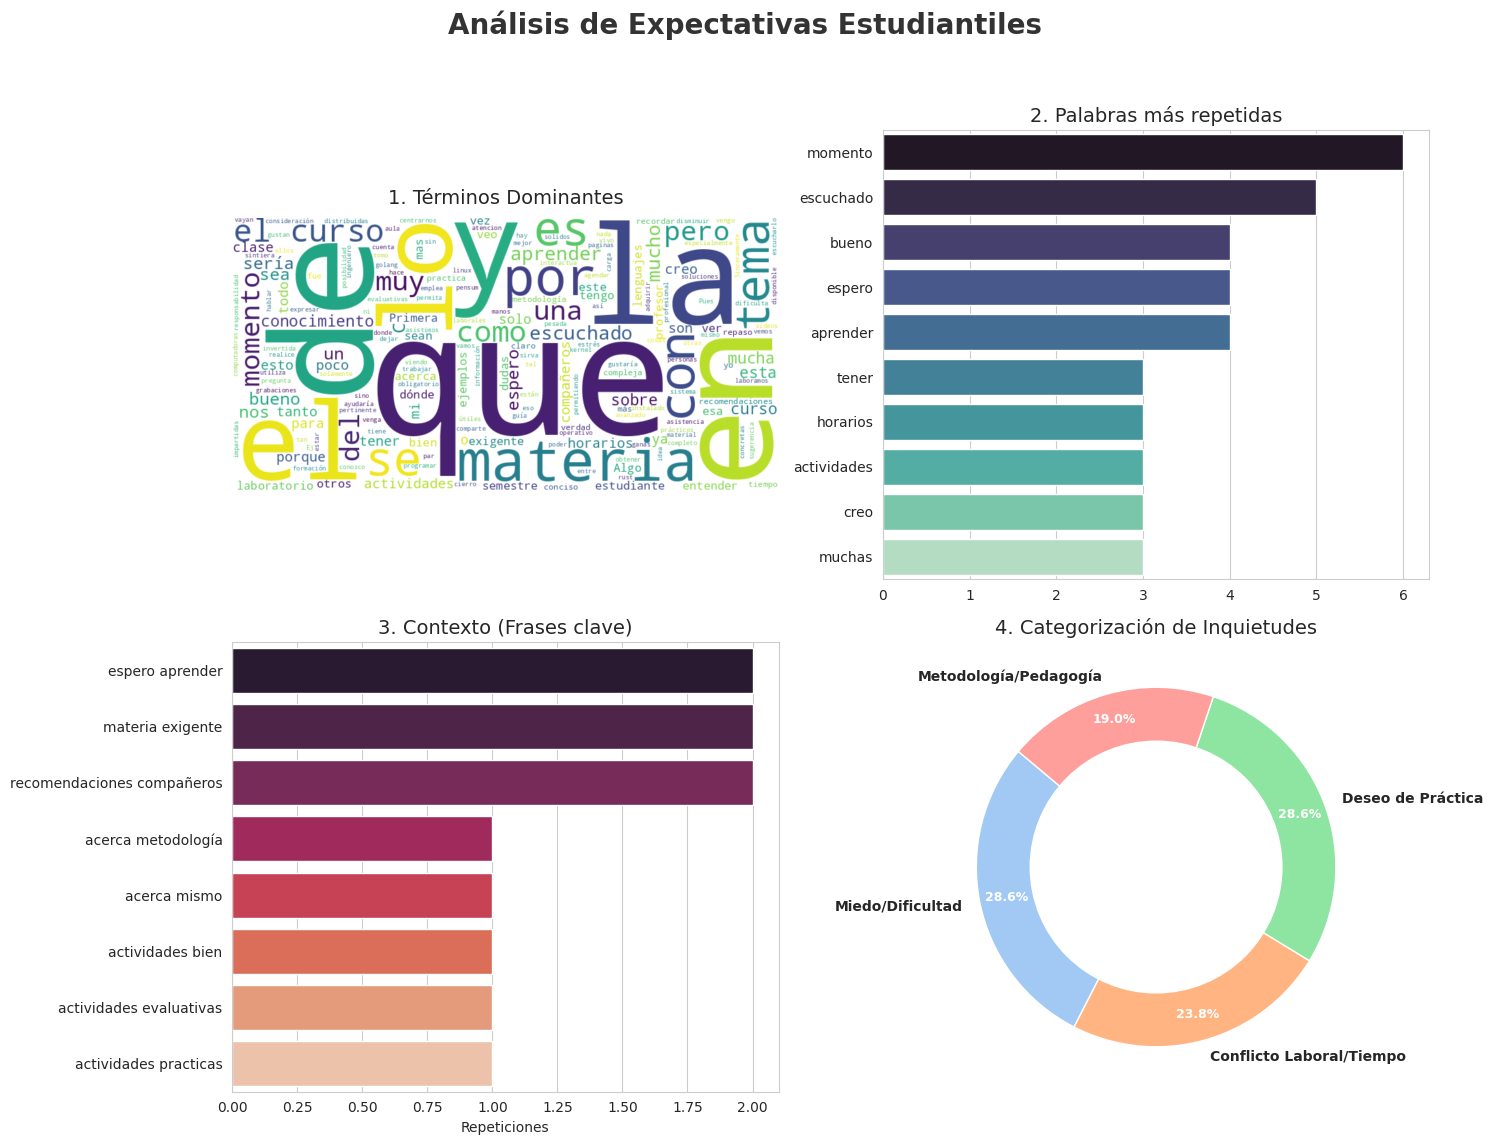

In [36]:
df_freq = analizar_frecuencia_palabras(lista_final, top_n=15) # 'resultado' es tu lista limpia
frases = extraer_frases_comunes(lista_final, n_gram=2, top_n=10)
# Para insights, necesitamos convertir el diccionario a DataFrame si la función anterior no lo hizo
detalles_insights = detectar_insights_semanticos(lista_final)
# NOTA: detectar_insights_semanticos en el código anterior imprimía pero retornaba 'detalles'.
# Vamos a crear el DataFrame manualmente aquí para el gráfico:
conteo_insights = {k: len(v) for k, v in detalles_insights.items()}
df_insights = pd.DataFrame(list(conteo_insights.items()), columns=['Categoría', 'Menciones'])

# 2. ¡Generar el Dashboard!
generar_dashboard_grafico(lista_final, df_freq, frases, df_insights)